In [1]:
import sys
import time
import numpy as np
#import tensorflow as tf
import pandas as pd
import seaborn as sns
import os
import psycopg2
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from datetime import datetime, timedelta
from multiprocessing import Pool, Manager
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sqlalchemy import create_engine
from urllib.parse import quote_plus
from datetime import datetime, timedelta
from multiprocessing import Pool, Manager
from dateutil.relativedelta import relativedelta


from darts import TimeSeries, concatenate
from darts.models import TFTModel
from darts.metrics import mape, smape , mae, rmse, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.utils.statistics import ModelMode

import calendar
import joblib
import argparse
import torch
import random
torch.backends.cudnn.deterministic = True


# Set seeds for reproducibility
seed = 42
rng = np.random.default_rng(seed=42)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set model parameters

In [2]:


TRAIN = "Yes"
PREDICT = "Yes"

Algo = "Temporal Fusion Transformer (TFT)"
Prediction_Range = 4
var_quart_pred_request = 4
current_date = datetime.now()
prediction =pd.DataFrame()
# outlier = 'No'  # to include outlier or not? 'No' 'Yes'
outlier =  sys.argv[3] if len(sys.argv) > 3 else "No"
metrics_results =pd.DataFrame()

var_output_string = ''
var_cti = 'Yes'
var_gdp = 'Yes'
var_us_gdp = 'No'

MODEL_DIR = 'Saved_Models\\'
MODEL_FILENAME_TEMPLATE = os.path.join(MODEL_DIR, 'Darts-TFT-{}')

my_model = None


# Data Loading from Database

In [3]:
# dbschema='schema1,schema2' # Searches left-to-right

# engine = create_engine('postgresql+psycopg2://username:%s@Host_ip/datbasename' % quote_plus("password"),connect_args={'options': '-csearch_path={}'.format(dbschema)})
# dbConnection    = engine.connect()
# source_data       = pd.read_sql("tablename", dbConnection)
# cti       =  pd.read_sql("cti_data", dbConnection) 
# gdp       =  pd.read_sql("gdp_data", dbConnection) 
# # closing sqlalchemy connection
# dbConnection.close()
# engine.dispose()

# Data Loading


In [4]:

# Load data from CSV
source_data = pd.read_csv('Data\cars.csv')
source_data
source_data['BOOKED DATE']=pd.to_datetime(source_data['BOOKED DATE'])

# Define an empty DataFrame outside of the if statement
cti = pd.DataFrame()
gdp = pd.DataFrame()

cti = pd.read_csv('Data\cti_data.csv')
gdp = pd.read_csv('Data\gdp_data.csv')


# Extracting start and end dates in the whole dataset, later used in the super-set
init_end_date = source_data['BOOKED DATE'].max()
init_start_date = source_data['BOOKED DATE'].min()


In [5]:


# Get the first day of the month
init_start_date = init_start_date.replace(day=1)
# Get the last day of the month
_, last_day = calendar.monthrange(init_end_date.year, init_end_date.month)
init_end_date = init_end_date.replace(day=last_day)


# Generate a DataFrame with a date range
date_range = pd.date_range(start=init_start_date, end=init_end_date, freq='D')
df = pd.DataFrame(date_range, columns=['date'])
# Extract month, quarter, and year from the date
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.to_period('Q')
df['year'] = df['date'].dt.year
# Count unique months per quarter
month_counts = df.groupby(['year','quarter'])['month'].nunique().reset_index(name='unique_months')
# Merge the month counts back to the original DataFrame
df = df.merge(month_counts, on='quarter')
# Remove records where the month count per quarter is less than 3
df = df[df['unique_months'] >= 3]
# Determine the first and last date of the resulting DataFrame
data_start_date = df['date'].min()
data_end_date = df['date'].max()

In [6]:

source_data=source_data.drop(source_data[source_data['BOOKED DATE']<data_start_date].index)

source_data=source_data.drop(source_data[source_data['BOOKED DATE']>data_end_date].index)

source_data=source_data[source_data['STATUS']=='CLOSED']

if outlier == 'No':  
    source_data=source_data.drop(source_data[source_data['MODEL']=='Toyota Prius'].index)
    source_data=source_data.drop(source_data[source_data['MODEL']=='Toyota RAV4'].index)
    source_data=source_data.drop(source_data[source_data['MODEL']=='Toyota Tacoma'].index)

source_data=source_data[['BOOKED DATE','MODEL','CUSTOMER','QUANTITY']]

source_data['BOOKED DATE']=pd.to_datetime(source_data['BOOKED DATE'])

source_data = source_data.sort_values(by=['BOOKED DATE'])

source_data['QUARTER']=source_data['BOOKED DATE'].dt.quarter

source_data['YEAR']=source_data['BOOKED DATE'].dt.year

source_data=source_data.drop('BOOKED DATE',axis=1)

source_data=source_data[['QUARTER','YEAR','MODEL','CUSTOMER','QUANTITY']]

source_data=source_data.reset_index(drop=True)

source_data = source_data.groupby(['QUARTER','YEAR','MODEL'])['QUANTITY'].sum().reset_index()

source_data.sort_values(by=['YEAR','QUARTER'], inplace=True)

data = source_data

data

,QUARTER,YEAR,MODEL,QUANTITY
0,1,2019,Toyota Avalon,50
1,1,2019,Toyota Camry,31
2,1,2019,Toyota Corolla,56
3,1,2019,Toyota Highlander,66
4,1,2019,Toyota Sienna,71
...,...,...,...,...
31,1,2024,Toyota Camry,81
32,1,2024,Toyota Corolla,73
33,1,2024,Toyota Highlander,68
34,1,2024,Toyota Sienna,76


# Exploratory Data Analysis (EDA)

This section provides insights into the dataset prior to modeling.

In [7]:

# Data Inspection
print("First few rows of the dataset:")
print(data.head())

print("\nSummary statistics:")
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values:")
print(missing_values)
    

First few rows of the dataset:
   QUARTER  YEAR              MODEL  QUANTITY
0        1  2019      Toyota Avalon        50
1        1  2019       Toyota Camry        31
2        1  2019     Toyota Corolla        56
3        1  2019  Toyota Highlander        66
4        1  2019      Toyota Sienna        71

Summary statistics:
          QUARTER         YEAR    QUANTITY
count  126.000000   126.000000  126.000000
mean     2.428571  2021.142857  104.214286
std      1.141428     1.526902   66.046118
min      1.000000  2019.000000   20.000000
25%      1.000000  2020.000000   60.000000
50%      2.000000  2021.000000   87.500000
75%      3.000000  2022.000000  126.000000
max      4.000000  2024.000000  417.000000

Missing values:
QUARTER     0
YEAR        0
MODEL       0
QUANTITY    0
dtype: int64


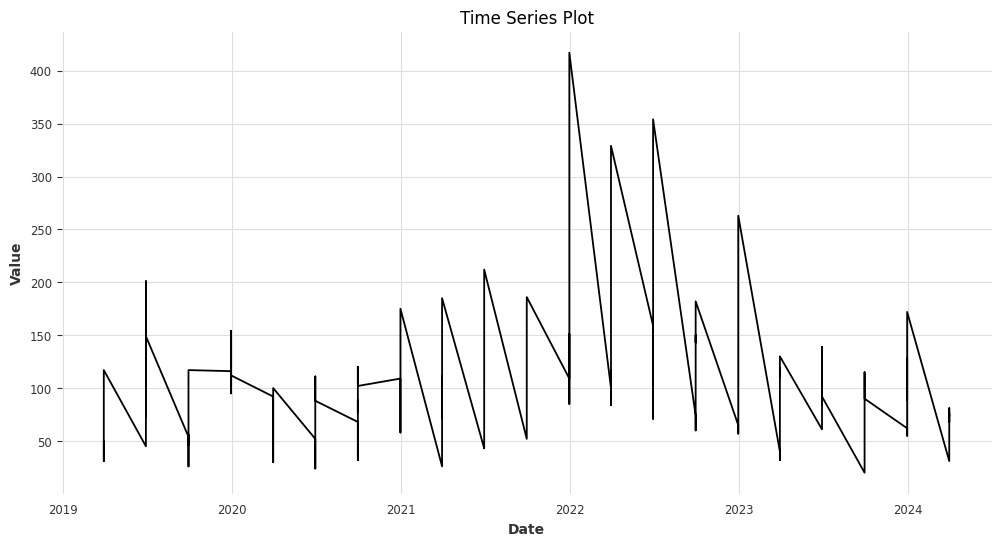

In [8]:
EDA=data.copy()

EDA.sort_values(by=['YEAR','QUARTER'], inplace=True)

EDA['YEAR_QUARTER'] = pd.to_datetime(EDA['YEAR'].astype(str) + '-' + (EDA['QUARTER'] * 3).astype(str) + '-01') + pd.offsets.MonthEnd(0)

# Plot time series data
plt.figure(figsize=(12, 6))
plt.plot(EDA['YEAR_QUARTER'], EDA['QUANTITY'])  # Replace 'date' and 'value' with your actual column names
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
    

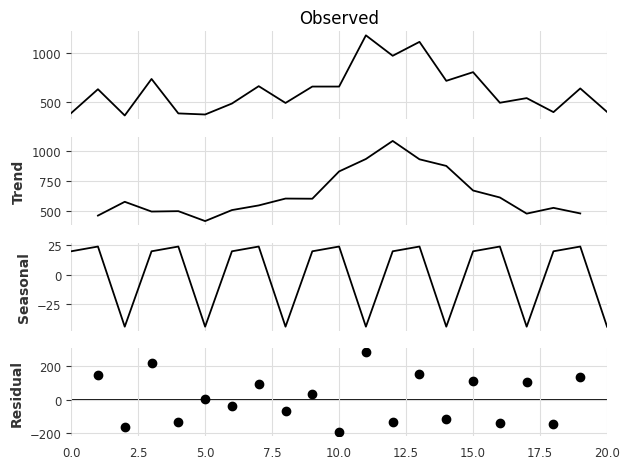

In [9]:

# Decompose the time series (if applicable)
from statsmodels.tsa.seasonal import seasonal_decompose

EDA['YEAR_QUARTER'] = pd.to_datetime(EDA['YEAR_QUARTER'])
EDA = EDA.groupby('YEAR_QUARTER')['QUANTITY'].sum().reset_index()


series = TimeSeries.from_dataframe(EDA, time_col='YEAR_QUARTER', value_cols='QUANTITY',fill_missing_dates=True, freq='Q' )  # Adjust columns
result = seasonal_decompose(series.values(), period=3)  # Adjust period if known
result.plot()
plt.show()

# Quarterly Date Preperation

In [10]:

past_cov_df=data.copy()

past_cov_df.sort_values(by=['YEAR','QUARTER'], inplace=True)

past_cov_df['YEAR_QUARTER'] = pd.to_datetime(past_cov_df['YEAR'].astype(str) + '-' + (past_cov_df['QUARTER'] * 3).astype(str) + '-01') + pd.offsets.MonthEnd(0)

# Drop unnecessary columns
past_cov_df = past_cov_df.drop(columns=['YEAR', 'QUARTER'])

final_df  = past_cov_df.copy() 

final_df = final_df.groupby(['YEAR_QUARTER', 'MODEL'])['QUANTITY'].sum().reset_index()
final_df

,YEAR_QUARTER,MODEL,QUANTITY
0,2019-03-31,Toyota Avalon,50
1,2019-03-31,Toyota Camry,31
2,2019-03-31,Toyota Corolla,56
3,2019-03-31,Toyota Highlander,66
4,2019-03-31,Toyota Sienna,71
...,...,...,...
121,2024-03-31,Toyota Camry,81
122,2024-03-31,Toyota Corolla,73
123,2024-03-31,Toyota Highlander,68
124,2024-03-31,Toyota Sienna,76


# Creating Future and Past Covariates

### Adding GDP and CTI Data


In [11]:

# Adding CTI Data
cti_df = cti.copy()
cti_df['date'] = pd.to_datetime(cti_df['date'])
future_end_date_cti_gdp= data_end_date + timedelta(days=365)
cti_df = cti_df[(cti_df['date'] >= data_start_date) & (cti_df['date'] <= future_end_date_cti_gdp)].sort_values(['date'])

if cti_df['date'].max()==future_end_date_cti_gdp:
    
    cti_df['date'] = pd.to_datetime(cti_df['date'])
    
    cti_df['QUARTER'] = cti_df['date'].dt.quarter
    cti_df['YEAR'] =  cti_df['date'].dt.year
    
    cti_df_filtered = cti_df.groupby(['YEAR','QUARTER'])['cti'].sum().reset_index()
    
    cti_df_filtered['YEAR_QUARTER'] = pd.to_datetime(cti_df_filtered['YEAR'].astype(str) + '-' + (cti_df_filtered['QUARTER'] * 3).astype(str) + '-01') + pd.offsets.MonthEnd(0)
    cti_df_filtered = cti_df_filtered.drop(columns=['YEAR', 'QUARTER'])
    cti_df_filtered.reset_index(drop=True, inplace=True)
    
else:
    print("Model Training : Required Future Date CTI data is not available.")
    sys.exit(1)


# Adding GDP Data
future_end_date_cti_gdp_firstday = future_end_date_cti_gdp.replace(day=1)
data_start_date_firstday = data_start_date.replace(day=1)

gdp_df = gdp.copy()
gdp_df['month'] = pd.to_datetime(gdp_df['month'])
gdp_df = gdp_df[(gdp_df['month'] >= data_start_date_firstday) & (gdp_df['month'] <= future_end_date_cti_gdp_firstday)]
												 
if gdp_df['month'].max()==future_end_date_cti_gdp_firstday:
    gdp_df['month'] = pd.to_datetime(gdp_df['month'])
    gdp_df['QUARTER'] = gdp_df['month'].dt.quarter
    gdp_df['YEAR'] = gdp_df['month'].dt.year
    
    gdp_df_filtered = gdp_df.groupby(['YEAR','QUARTER'])['gdp'].mean().reset_index()
    
    gdp_df_filtered['YEAR_QUARTER'] = pd.to_datetime(gdp_df_filtered['YEAR'].astype(str) + '-' + (gdp_df_filtered['QUARTER'] * 3).astype(str) + '-01') + pd.offsets.MonthEnd(0)
    gdp_df_filtered = gdp_df_filtered.drop(columns=['YEAR', 'QUARTER'])
    gdp_df_filtered.reset_index(drop=True, inplace=True)
    
else:
    print("Model Training : Required Future Date GDP data is not available.")
    sys.exit(1)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13352\2131338304.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cti_df['date'] = pd.to_datetime(cti_df['date'])


### Merging GDP Data with Future Covariates and Adding New Features


In [12]:

future_covar = gdp_df_filtered.copy()

# Feature Engineering
future_covar['year'] = future_covar['YEAR_QUARTER'].dt.year
future_covar['quarter'] = future_covar['YEAR_QUARTER'].dt.quarter

future_covar

,gdp,YEAR_QUARTER,year,quarter
0,2.8,2019-03-31,2019,1
1,2.8,2019-06-30,2019,2
2,2.8,2019-09-30,2019,3
3,2.8,2019-12-31,2019,4
4,-2.7,2020-03-31,2020,1
5,-2.7,2020-06-30,2020,2
6,-2.7,2020-09-30,2020,3
7,-2.7,2020-12-31,2020,4
8,6.5,2021-03-31,2021,1
9,6.5,2021-06-30,2021,2


# Creating past Covariates


In [13]:

def create_past_covariates(df_or_ts):
    # Check if the input is already a TimeSeries
    if isinstance(df_or_ts, TimeSeries):
        # Convert TimeSeries to DataFrame
        past_cov = df_or_ts.pd_dataframe(copy=True, suppress_warnings=False)
        past_cov = past_cov.reset_index()
    else:
        past_cov = df_or_ts.copy()
        
    
    # Convert 'YEAR-QUARTER' column to datetime type
    past_cov['YEAR_QUARTER'] = pd.to_datetime(past_cov['YEAR_QUARTER'])
    
    # Set 'YEAR-QUARTER' column as index
    past_cov.set_index('YEAR_QUARTER', inplace=True)
    
    # Create binary trend column
    past_cov['BINARY_TREND'] = (past_cov['QUANTITY'] > past_cov['QUANTITY'].shift(1)).astype(int)

   
    # Create lag columns
    for i in range(1, 4):
        past_cov[f'lag_{i}'] = past_cov['QUANTITY'].shift(i)
    
    # Fill missing values with 0
    past_cov = past_cov.fillna(0)

    # Rolling mean and std
    past_cov['rolling_mean'] = past_cov['QUANTITY'].rolling(window=3).mean()
    past_cov['rolling_std'] = past_cov['QUANTITY'].rolling(window=3).std()
    
    # Difference features
    past_cov['quantity_diff1'] = past_cov['QUANTITY'].diff(1)
    past_cov['quantity_diff2'] = past_cov['QUANTITY'].diff(2)

    past_cov =  pd.merge(past_cov, cti_df_filtered, how='left', on='YEAR_QUARTER')

    past_cov.set_index('YEAR_QUARTER', inplace=True)

    past_cov =past_cov.fillna(0)
    past_cov_trend = past_cov.reset_index()
  
    series = TimeSeries.from_dataframe(past_cov_trend, time_col='YEAR_QUARTER', value_cols='QUANTITY')

    is_seasonal, period = check_seasonality(series, alpha=0.05, m=None)

    if is_seasonal:
        trend, seasonal = extract_trend_and_seasonality(series, period=period)
        past_cov['trend'] = trend.pd_dataframe()
        past_cov['seasonal'] = seasonal.pd_dataframe()
        
    else:
        past_cov['trend'] = 0
        past_cov['seasonal'] = 0

    
   

    past_cov = past_cov.fillna(0)
    
    # Drop 'QUANTITY' column
    past_cov = past_cov.drop(columns=['QUANTITY']).reset_index()

    
    #Convert DataFrame to TimeSeries
    past_series = TimeSeries.from_dataframe(past_cov,
                                             time_col='YEAR_QUARTER',
                                            value_cols=['cti','lag_1','lag_3', 'trend',  'seasonal', 'BINARY_TREND','rolling_mean', 'rolling_std',
                                                        'quantity_diff1', 'quantity_diff2' ],
                                             freq='Q')



    return past_series
 

# Prediction Range


In [14]:

# generate future start and end date

future_start_date = data_end_date + timedelta(days=1)
if calendar.isleap(data_end_date.year + 1):
    future_end_date = data_end_date + timedelta(days=366)
else:
    future_end_date = data_end_date + timedelta(days=365)
    

future_start_date = data_end_date + timedelta(days=1)
future_start_date = pd.to_datetime(future_start_date)

future_end_date = pd.to_datetime(future_end_date)


In [15]:

#Generate a range of dates
date_range = pd.date_range(start=future_start_date, end=future_end_date, freq='D')  # Monthly frequency
#Create a DataFrame with the date range
df = pd.DataFrame({'date': date_range})
# Extract month, quarter, and year
df['month'] = df['date'].dt.month
df['QUARTER'] = df['date'].dt.quarter
df['YEAR'] = df['date'].dt.year

# Remove the date column
del df['date']

# Group by quarter,year and filter out groups with months less than 3 occurrences and order them on year and quarter
df_grouped = df.groupby(['QUARTER', 'YEAR'])['month'].nunique().reset_index().sort_values(by=['YEAR', 'QUARTER'])


# Find the last quarter
last_quarter = df_grouped.loc[df_grouped.index[-1], ['QUARTER', 'YEAR']]

df_filtered = df_grouped[df_grouped['month'] == 3].drop(columns='month')
df_filtered = df_grouped[~((df_grouped['QUARTER'] == last_quarter['QUARTER']) & (df_grouped['YEAR'] == last_quarter['YEAR']) & (df_grouped['month'] < 3))].drop(columns='month')

df_year_quarter = df_filtered.sort_values(by=['YEAR', 'QUARTER']).reset_index(drop=True)

df_year_quarter = df_year_quarter.head(var_quart_pred_request)


In [16]:

# Get the first record (quarter and year)
first_record = df_year_quarter.iloc[0]
# Get the last record (quarter and year)
last_record = df_year_quarter.iloc[-1]
# Concatenate the first and last quarter-year values to create the desired variable value
Prediction_Range = f"{first_record['YEAR']}_Q{first_record['QUARTER']} To {last_record['YEAR']}_Q{last_record['QUARTER']}"
Prediction_Range

'2024_Q2 To 2025_Q1'

# Covenerting data into Times Series Data


In [17]:

def create_time_series(df, model):
    model_df = df[df['MODEL'] == model]
    series = TimeSeries.from_dataframe(model_df, time_col='YEAR_QUARTER',fill_missing_dates=True, fillna_value=0,value_cols='QUANTITY', freq='Q')
    return series


time_series_dict = {}

for model in final_df['MODEL'].unique():
    time_series_dict[model] = create_time_series(final_df, model)




future_series = TimeSeries.from_dataframe(future_covar,
                                    time_col='YEAR_QUARTER',
                                         value_cols = ['gdp','year' ,'quarter' ],
                                         freq = 'Q' )




# Defining Model and its Parameters


# Fitting The Model


# Tuned Best Parameters

In [18]:

def load_best_hyperparameters(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Initialize an empty dictionary for storing hyperparameters
    tft_params_dict = {}
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        model_name = row['Model']
        MAPE = row['MAPE']
        
        tft_params_dict[model_name] = {
            'input_chunk_length': row['input_chunk_length'],
            'output_chunk_length': row['output_chunk_length'],
            'hidden_size': row['hidden_size'],
            'lstm_layers': row['lstm_layers'],
            'num_attention_heads': row['num_attention_heads'],
            'dropout': row['dropout'],
            'batch_size': row['batch_size'],
            'optimizer_lr': row['lr'],
        }   
    return tft_params_dict


# Example usage

file_path = "Data\\best_hyperparameters_summary.csv"
tft_params_dict = load_best_hyperparameters(file_path)
tft_params_dict

{'Toyota Avalon': {'input_chunk_length': 6,
  'output_chunk_length': 4,
  'hidden_size': 15,
  'lstm_layers': 3,
  'num_attention_heads': 4,
  'dropout': 0.255579944,
  'batch_size': 32,
  'optimizer_lr': 8.85e-05},
 'Toyota Corolla': {'input_chunk_length': 8,
  'output_chunk_length': 4,
  'hidden_size': 29,
  'lstm_layers': 10,
  'num_attention_heads': 4,
  'dropout': 0.274962767,
  'batch_size': 16,
  'optimizer_lr': 3.28e-05},
 'Toyota Sienna': {'input_chunk_length': 6,
  'output_chunk_length': 4,
  'hidden_size': 29,
  'lstm_layers': 5,
  'num_attention_heads': 7,
  'dropout': 0.241050997,
  'batch_size': 16,
  'optimizer_lr': 2.57e-05},
 'Toyota Camry': {'input_chunk_length': 8,
  'output_chunk_length': 4,
  'hidden_size': 24,
  'lstm_layers': 4,
  'num_attention_heads': 11,
  'dropout': 0.236091989,
  'batch_size': 16,
  'optimizer_lr': 1.61e-05},
 'Toyota Highlander': {'input_chunk_length': 6,
  'output_chunk_length': 4,
  'hidden_size': 16,
  'lstm_layers': 14,
  'num_attention

In [19]:

from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import logging
import warnings
import sys
import os
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
logging.getLogger('torch').setLevel(logging.CRITICAL)
logging.getLogger('darts').setLevel(logging.CRITICAL)
logging.getLogger('pytorch_lightning').setLevel(logging.CRITICAL)
logging.getLogger('lightning').setLevel(logging.CRITICAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)


def train_model(series_transformed, past_transformed, future_transformed, model,tft_params):
    global my_model
    print(f"\nModel Training : Training for CAR-Model '{model}'")
	
    my_stopper = EarlyStopping(
        monitor="train_loss",
        patience=8,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs = {"callbacks": [my_stopper],"enable_progress_bar": False, "logger": False }
    
    # Define add_encoders dictionary with updated encoder parameters
    add_encoders = {
        'cyclic': {'future': ['quarter']},  # Specify quarterly cyclic encoding
        'datetime_attribute': {'future': ['quarter']},  # Update to include only 'quarter'
        'position': {'past': ['relative'], 'future': ['relative']},
        'transformer': Scaler(scaler=MinMaxScaler(feature_range=(0, 1)))
    }

    my_model = TFTModel(
        input_chunk_length=tft_params['input_chunk_length'],
        output_chunk_length=tft_params['output_chunk_length'],
        hidden_size=tft_params['hidden_size'],
        lstm_layers=tft_params['lstm_layers'],
        num_attention_heads=tft_params['num_attention_heads'],
        dropout=tft_params['dropout'],
        batch_size=tft_params['batch_size'],
        n_epochs=300,
        add_relative_index=False,
        full_attention = True,
        add_encoders=add_encoders,
        pl_trainer_kwargs = pl_trainer_kwargs,
        optimizer_kwargs={"lr": tft_params['optimizer_lr']},
        
        random_state=42
    )
    my_model.fit(series=series_transformed, past_covariates=past_transformed, future_covariates=future_transformed, verbose=False)
    
    # model_name = f"Darts_TFT_outlier_{outlier}"
    # ml_model_path = f"{file_path}{model_name}{model}"
    # my_model.save(ml_model_path)

    model_file_name_train = MODEL_FILENAME_TEMPLATE.format(model)
    my_model.save(model_file_name_train)

    
    print(f"\r\nModel Training : AI-Model Saved as 'Darts-TFT-{model}'\r\n")
    # time.sleep(2)

    return model_file_name_train



def predict_model(n, model):
    global my_model
    model_file_name_pred = MODEL_FILENAME_TEMPLATE.format(model)
    print(f"\r\nDemand Prediction : Using AI-Model: 'Darts-TFT-{model}'\r\n")
    # time.sleep(2)
    my_model = TFTModel.load(model_file_name_pred)
 
    pred = my_model.predict(n=n, verbose=False)
    # print(pred)        
    return pred
    


def perform_backtest(series_transformed, past_transformed, future_transformed, model):
    model_file_name_mape= MODEL_FILENAME_TEMPLATE.format(model)
    # print(f"\r\nBacktesting : Using Model: '{model_file_name_mape}'\r\n")
    # time.sleep(2)
    my_model = TFTModel.load(model_file_name_mape)

    end_time = series_transformed.end_time()
    start_time = end_time - ( 3 * series_transformed.freq)
    backtest_series = my_model.historical_forecasts(
        series_transformed,
        future_covariates=future_transformed,
        past_covariates= past_transformed,
        start=start_time,
        # num_samples=200,
        forecast_horizon=4,
        stride=1,
        last_points_only=False,
        retrain=True,
        verbose=False,
	show_warnings=False
        )

    return backtest_series



def eval_backtest(backtest_series, actual_series, horizon, start, transformer):

    actual_series_inv = transformer.inverse_transform(actual_series)
    backtest_series_inv = transformer.inverse_transform(backtest_series)
    
    # Calculate various metrics
    mape_value = mape(actual_series_inv, backtest_series_inv)
    mae_value = mae(actual_series_inv, backtest_series_inv)
    rmse_value = rmse(actual_series_inv, backtest_series_inv)
    smape_value = smape(actual_series_inv, backtest_series_inv)
    r2_value = r2_score(actual_series_inv, backtest_series_inv)
    
    
    metrics_value = {
    'MAE': None,
    'MAPE': None,
    'RMSE': None,
    'SMAPE': None,
    'R2': None
    }

    metrics_value['MAE'] =  mae_value
    metrics_value['MAPE']= mape_value
    metrics_value['RMSE']= rmse_value
    metrics_value['SMAPE']=smape_value
    metrics_value['R2']= r2_value

    return metrics_value




# Main Function 



Model Training : Starting Training for Algo: 'Temporal Fusion Transformer (TFT)' without Outlier and with Covariates


Model Training : Training for CAR-Model 'Toyota Avalon'

Model Training : AI-Model Saved as 'Darts-TFT-Toyota Avalon'


Demand Prediction : Using AI-Model: 'Darts-TFT-Toyota Avalon'


Model Training : Training for CAR-Model 'Toyota Camry'

Model Training : AI-Model Saved as 'Darts-TFT-Toyota Camry'


Demand Prediction : Using AI-Model: 'Darts-TFT-Toyota Camry'


Model Training : Training for CAR-Model 'Toyota Corolla'

Model Training : AI-Model Saved as 'Darts-TFT-Toyota Corolla'


Demand Prediction : Using AI-Model: 'Darts-TFT-Toyota Corolla'


Model Training : Training for CAR-Model 'Toyota Highlander'

Model Training : AI-Model Saved as 'Darts-TFT-Toyota Highlander'


Demand Prediction : Using AI-Model: 'Darts-TFT-Toyota Highlander'


Model Training : Training for CAR-Model 'Toyota Sienna'

Model Training : AI-Model Saved as 'Darts-TFT-Toyota Sienna'


Demand Predi

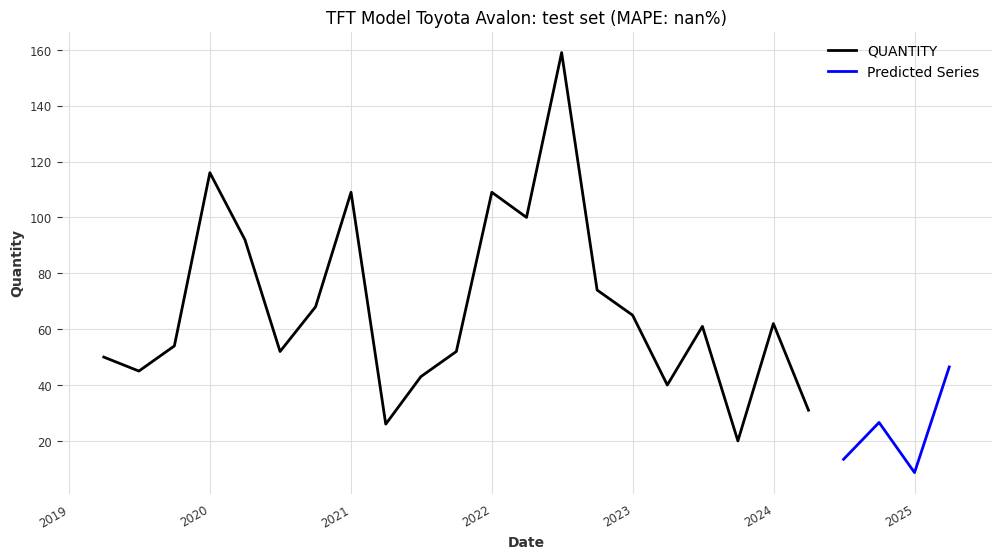

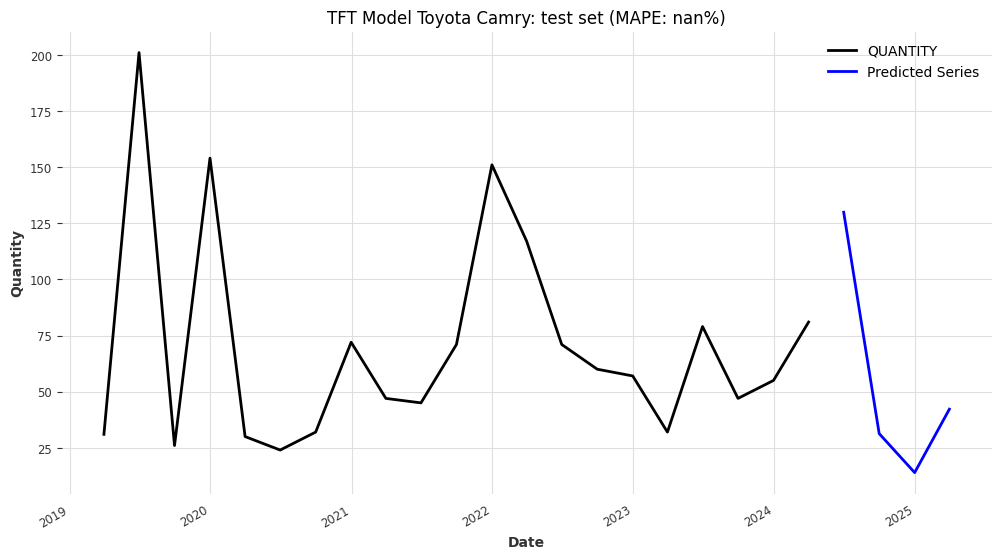

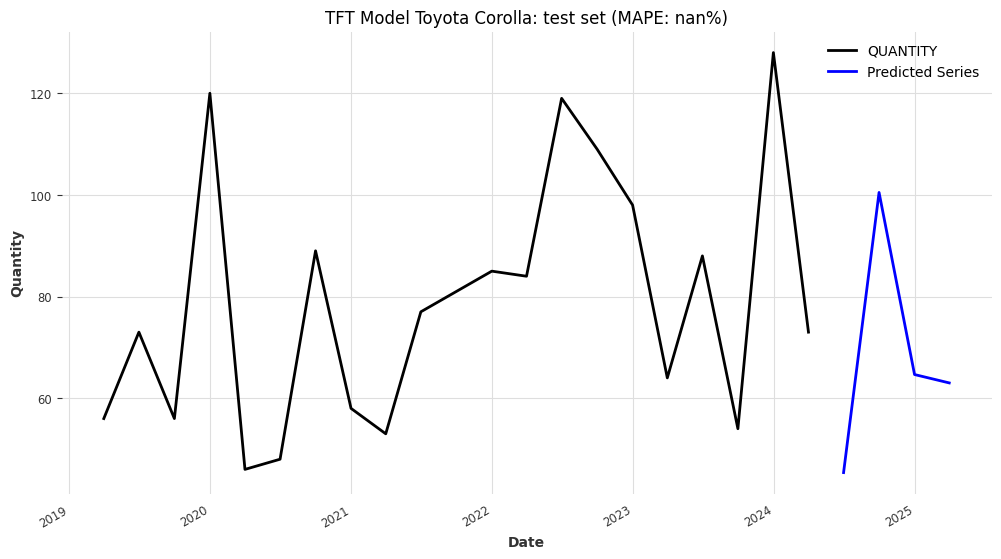

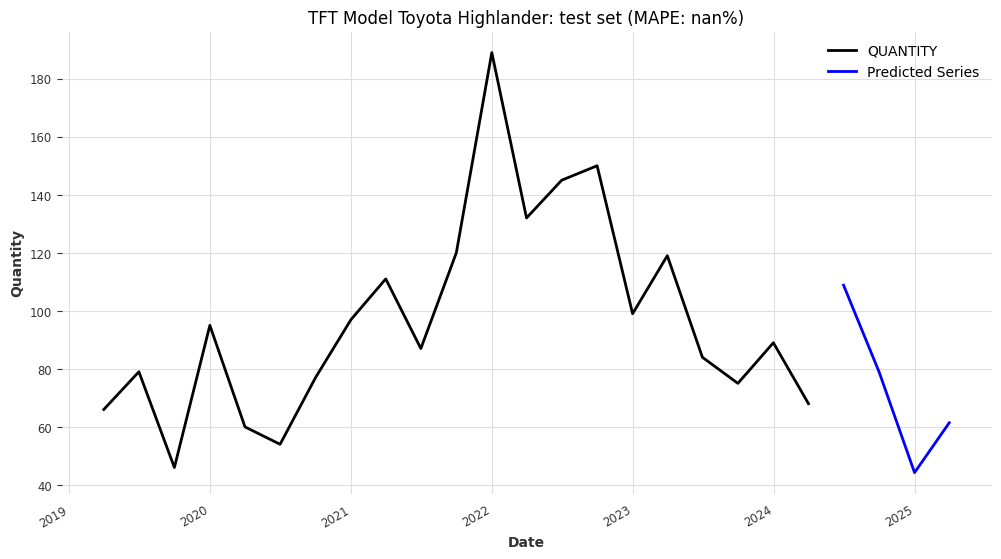

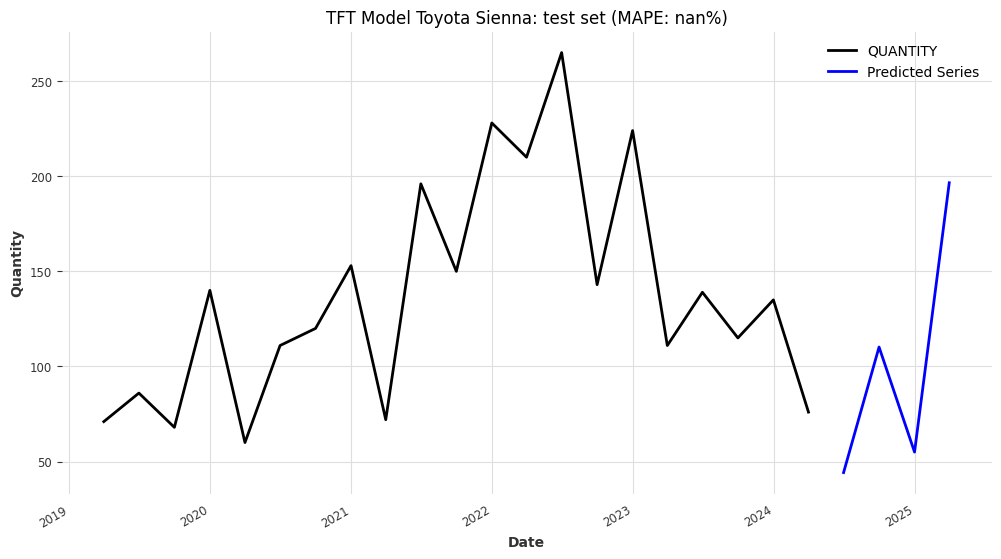

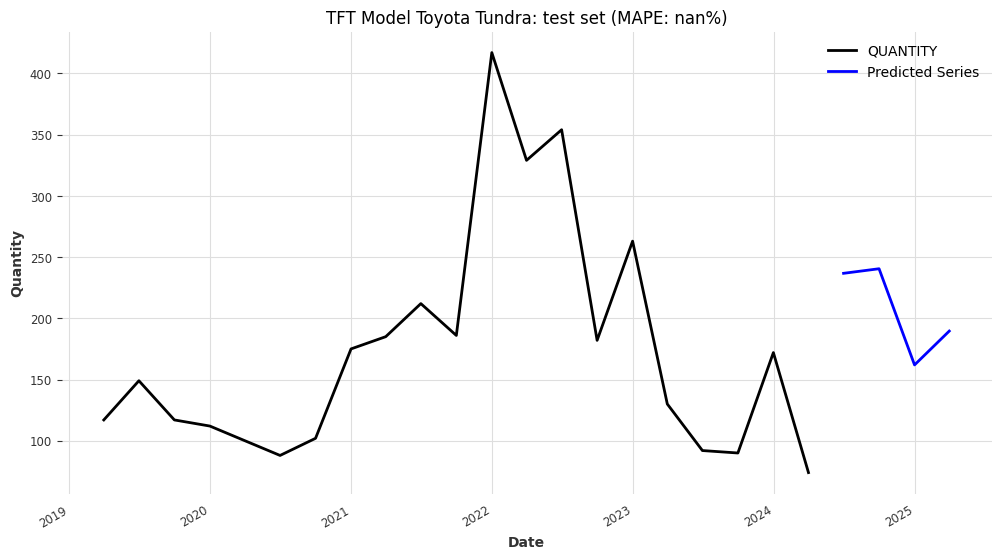

In [20]:


def main():
    global TRAIN, PREDICT ,prediction,metrics_results

    if TRAIN == 'Yes':
        print(f"\r\nModel Training : Starting Training for Algo: '{Algo}' {'without Outlier' if outlier == 'No' else 'with Outlier'}{' and with Covariates' if var_cti == 'Yes' else ' and without Covariates'}\r\n")
    else:
        print(f"\r\nDemand Prediction : Starting Demand Prediction Using Algo: '{Algo}' {'without Outlier' if outlier == 'No' else 'with Outlier'}{' and with Covariates' if var_cti == 'Yes' else ' and without Covariates'}\r\n")

    for model, series in time_series_dict.items():
        
        # Split Date
        series_end_date = series.end_time()        
        split_date = series_end_date - relativedelta(years=1)
    
     
            # Initialize the Scaler for Original Series with MinMaxScaler
        scaler = Scaler(scaler=MinMaxScaler(feature_range=(0, 1)))
        train, val = series.split_after(split_date)
        train_transformed = scaler.fit_transform(train)
        val_transformed = scaler.transform(val)
        series_transformed = scaler.transform(series)
            
            # Initialize the Scaler for Future Series with MinMaxScaler
        future_scaler = Scaler(scaler=MinMaxScaler(feature_range=(0, 1)))
        train_future, val_future = future_series.split_after(split_date)
        future_scaler.fit(train_future)
        future_transformed = future_scaler.transform(future_series)
            
            # Initialize the Scaler for Past Series
        past_df_filtered = past_cov_df[past_cov_df['MODEL'] == model]
        past_df_filtered = past_df_filtered.groupby(['YEAR_QUARTER'])['QUANTITY'].sum().reset_index()
        past_series = create_past_covariates(past_df_filtered)
        # print(past_series)
            
        past_scaler = Scaler(scaler=MinMaxScaler(feature_range=(0, 1)))
        train_past, val_past = past_series.split_after(split_date)
        past_scaler.fit(train_past)
        past_transformed = past_scaler.transform(past_series)
        

        tft_params = tft_params_dict[model]
        
        if TRAIN == 'Yes':
            train_model(series_transformed, past_transformed, future_transformed, model,tft_params)
    
        if PREDICT == 'Yes':
            # print("Predicting with the model...")
            predictions = predict_model(4 , model)

            
            backtest = perform_backtest(series_transformed, past_transformed, future_transformed, model)
            
            metrics_value= eval_backtest( backtest_series = concatenate(backtest), actual_series=series_transformed, horizon=4,start=split_date, transformer = scaler)
            
            metrics_value_df = pd.DataFrame([metrics_value])
            metrics_value_df['Model'] = model
            metrics_value_df['Algorithm'] = Algo
            metrics_results = pd.concat([metrics_results, metrics_value_df])

            
            pred_inverse = scaler.inverse_transform(predictions)
            val_inverse = scaler.inverse_transform(val_transformed)
                  
            pred_inverse = scaler.inverse_transform(predictions)
            val_inverse = scaler.inverse_transform(val_transformed)


            plt.figure(figsize=(12, 6))
            series.plot() 
            pred_inverse.plot(color='blue',label='Predicted Series')
                        # Adding labels and title
            plt.xlabel('Date')
            plt.ylabel('Quantity')
            plt.title(f"TFT Model {model}: test set (MAPE: {mape(val_inverse, pred_inverse):.2f}%)")
            plt.legend()
            
            
            # Prepare pred_final DataFrame
            pred_final = pred_inverse.pd_dataframe(copy=True, suppress_warnings=False)


            pred_final['MODEL'] = model
            pred_final['QUANTITY'] = pred_final['QUANTITY'].round(0)
            pred_final = pred_final.rename(columns={'QUANTITY': 'PREDICT QTY'})
            pred_final = pred_final.reset_index()

            prediction = pd.concat([prediction , pred_final])
    
    if TRAIN == 'Yes':
        print(f"\r\nModel Training : Training Using '{Algo}' Completed \r\n")
        # time.sleep(2)
	
    if PREDICT == 'Yes':
        print(f"\r\nDemand Prediction : Prediction Using '{Algo}' Completed \r\n")
        # time.sleep(2)
		
    if TRAIN == 'No' and PREDICT == 'No':
        print("No action specified. Set TRAIN and/or PREDICT to True.")

    return prediction, metrics_results

if __name__ == "__main__":
    main()
   

# Preparing Data in proper format

In [21]:

# Preparing Data in proper Format
if PREDICT == 'Yes':

    format_data = pd.DataFrame()
   
    orignal_df = final_df.copy()         
    format_data_func = pd.merge(prediction, orignal_df, on=['YEAR_QUARTER', 'MODEL'], how='outer')
    format_data_func = format_data_func.fillna(0)
    format_data_func = format_data_func.sort_values(by=['YEAR_QUARTER'])
    format_data_func = format_data_func.rename(columns={'QUANTITY': 'ORIG QTY', 'YEAR_QUARTER': 'QUARTER-YEAR'}).reset_index(drop=True)
    
    format_data_func['Algo'] = Algo
    format_data_func['Execution_Date'] = current_date
    format_data_func['With_Outlier'] = outlier
    format_data_func['Execution_Date'] = pd.to_datetime(format_data_func['Execution_Date'])
    format_data_func['Prediction_Range'] = Prediction_Range
    format_data_func['CUSTOMER'] = "CUSTOMER-1"
    format_data_func['QUARTER'] = format_data_func['QUARTER-YEAR'].dt.quarter
    format_data_func['YEAR'] = format_data_func['QUARTER-YEAR'].dt.year
    format_data_func['QUARTER-YEAR'] = format_data_func['YEAR'].astype(str) + ' ' + 'Q' + format_data_func['QUARTER'].astype(str)
                     
            
            # Update format_data
    format_data = format_data_func[['QUARTER', 'YEAR', 'MODEL', 'CUSTOMER', 'PREDICT QTY',
                                              'ORIG QTY', 'QUARTER-YEAR', 'Algo', 'Prediction_Range', 'Execution_Date', 'With_Outlier']]
            
            # Example condition using first_record
    condition = (format_data['YEAR'] > first_record['YEAR']) | ((format_data['YEAR'] == first_record['YEAR']) & (format_data['QUARTER'] >= first_record['QUARTER']))
    
            # Apply the condition to filter the DataFrame
    filtered_data = format_data[condition]
            # print(filtered_data)

filtered_data

,QUARTER,YEAR,MODEL,CUSTOMER,PREDICT QTY,ORIG QTY,QUARTER-YEAR,Algo,Prediction_Range,Execution_Date,With_Outlier
126,2,2024,Toyota Avalon,CUSTOMER-1,13.0,0.0,2024 Q2,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
127,2,2024,Toyota Corolla,CUSTOMER-1,45.0,0.0,2024 Q2,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
128,2,2024,Toyota Highlander,CUSTOMER-1,109.0,0.0,2024 Q2,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
129,2,2024,Toyota Sienna,CUSTOMER-1,44.0,0.0,2024 Q2,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
130,2,2024,Toyota Camry,CUSTOMER-1,130.0,0.0,2024 Q2,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
131,2,2024,Toyota Tundra,CUSTOMER-1,237.0,0.0,2024 Q2,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
132,3,2024,Toyota Sienna,CUSTOMER-1,110.0,0.0,2024 Q3,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
133,3,2024,Toyota Avalon,CUSTOMER-1,27.0,0.0,2024 Q3,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
134,3,2024,Toyota Camry,CUSTOMER-1,31.0,0.0,2024 Q3,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
135,3,2024,Toyota Highlander,CUSTOMER-1,79.0,0.0,2024 Q3,Temporal Fusion Transformer (TFT),2024_Q2 To 2025_Q1,2024-12-02 14:41:13.117536,No
